In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [5]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [6]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)


(9, 9) (1, 9)
(9, 9) (1, 9)
Alphas for hard margins:  [[3.71104471e+00]
 [1.33021505e-11]
 [4.91934193e-12]
 [1.20779362e-11]
 [8.76891078e-11]
 [5.84540963e-12]
 [5.04187786e-12]
 [8.34357085e-12]
 [1.85501168e+01]
 [1.24764208e-09]
 [2.63120875e-09]
 [8.85733556e-12]
 [4.80855393e-12]
 [8.99532883e-12]
 [8.06051364e-12]
 [3.03804437e-11]
 [5.34023732e-12]
 [1.16830802e-11]
 [5.89814350e-12]
 [1.01455161e-11]
 [6.37072009e-12]
 [6.89894338e-12]
 [4.45930290e-12]
 [5.61636805e-12]
 [5.93266101e-12]
 [5.75458168e-12]
 [6.96204324e-11]
 [1.56924608e-11]
 [1.66107458e+01]
 [1.13991487e-11]
 [1.89176729e-10]
 [4.20158488e-12]
 [1.48365694e-11]
 [7.50642655e-12]
 [1.90230489e-11]
 [1.10658881e-11]
 [5.12852552e-12]
 [5.18771651e-12]
 [7.44794264e-12]
 [1.56733156e-11]
 [1.05277149e-11]
 [7.16355271e-12]
 [4.81660086e-12]
 [1.03497735e-11]
 [5.28350956e-12]
 [5.11423289e-12]
 [1.19954184e-11]
 [8.60774492e-12]
 [3.51447313e-10]
 [2.84050567e-11]
 [9.38174575e-12]
 [2.04574286e-11]
 [6.391692

In [7]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[3.71104471e+00]
 [2.36184423e-11]
 [1.01353217e-11]
 [2.27258533e-11]
 [7.55270390e-11]
 [1.18098811e-11]
 [9.73583856e-12]
 [1.20872820e-11]
 [1.85501168e+01]
 [6.33667328e-10]
 [1.25517300e-09]
 [1.80752684e-11]
 [8.10941809e-12]
 [1.74021946e-11]
 [1.53418156e-11]
 [6.18873313e-11]
 [1.06310431e-11]
 [2.19035829e-11]
 [1.16743336e-11]
 [2.17932261e-11]
 [1.15208041e-11]
 [1.28683806e-11]
 [9.40869347e-12]
 [1.09784660e-11]
 [1.07966775e-11]
 [9.84224080e-12]
 [1.55730991e-10]
 [3.15713488e-11]
 [1.66107458e+01]
 [2.03706375e-11]
 [1.02664474e-10]
 [8.01387626e-12]
 [2.65117321e-11]
 [1.70550911e-11]
 [3.77161881e-11]
 [2.31042888e-11]
 [9.01113196e-12]
 [9.35112160e-12]
 [1.46865610e-11]
 [3.08311345e-11]
 [2.07147935e-11]
 [1.53333673e-11]
 [8.88368468e-12]
 [1.94977076e-11]
 [9.99428588e-12]
 [9.96466883e-12]
 [2.12421615e-11]
 [1.53104425e-11]
 [7.78721448e-11]
 [4.46155686e-11]
 [1.93826927e-11]
 [3.59669918e-11]
 [1.20442142e-11]
 [1.52744504e-11]
 [

<a list of 4 text.Text objects>

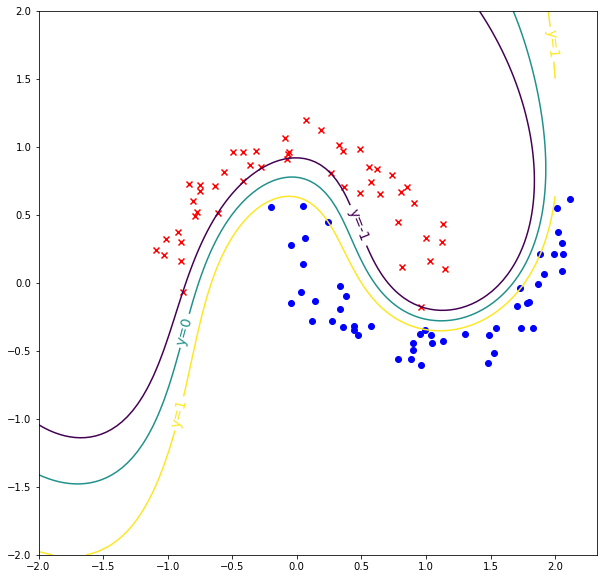

In [8]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=14)

<a list of 4 text.Text objects>

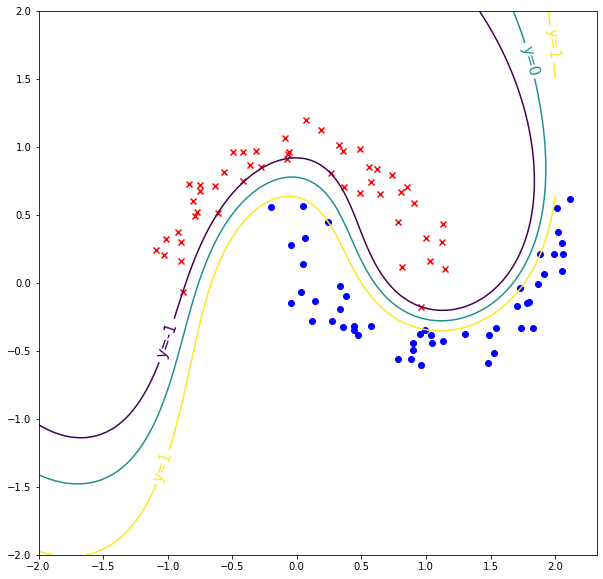

In [9]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)